# Deutsch-Jozsa Algorithm
<hr></hr>

Deutsch's algorithm (named after [David Deutsch](https://en.wikipedia.org/wiki/David_Deutsch)) was the first demonstration of how quantum computing provides an advantage over classical computational methods [[Deutsch85](https://www.cs.princeton.edu/courses/archive/fall06/cos576/papers/deutsch85.pdf)]. The algorithm was later generalized for more than one qubit by David Deutsch and Ricahrd Jozsa [[Deutsch92](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.1992.0167)], in what is today known as the [Deutsch-Jozsa algorithm](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm).

Even though these two algorithms do not solve problems of practical relevance, they are of indisputable historical importance and laid the foundation for the development of all other quantum algorithms known today.

## 1. Deutsch's Algorithm

The formulation of the popularized version of Deutsch's algorithm was first presented by Richard Cleve, et. al. in 1997 [[Cleve97](https://arxiv.org/abs/quant-ph/9708016)]. It differs from Deutsch's original proposal in that it **deterministically** provides the right solution to what is known as Deutsch's problem in a single try. On the other hand, a classical strategy can at best provide the right answer 50% of the time by trying to guess, or takes two tries to guarantee getting the right answer.

We will start by describing of how the algorithm works by casting it as a guessing game, followed by a formal definition in terms of the [quantum function evaluation](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#quantum-function-evaluation) strategy we previously discussed.

### 1.1 General Overview

A relatively intuitive way to understand Deutsch's problem is by setting it up in the form of a game. 

Imagine you are presented with a black box with two inputs and two outputs.

<img src="images/04_01_01_black_box.png" align = "center" width="700"/>

The box is "black" because you can't see what's inside; however, you are told that, with certainty, the box corresponds to one of four possible reversible circuits:

<img src="images/04_01_02_oracles.png" align = "center" width="750"/>

1. The first circuit is simple, both inputs go straight to the output.

2. The second circuit is similar, except the bottom input is always negated.

3. In the third circuit, the bottom output gets negated _if_ the top input is 1.

4. In the fourth circuit, the bottom output gets negated _if_ the top input is 0.

There are then two types of circuits: 

$\text{I}$. Those where the top and bottom paths are independent of each other (circuits 1 and 2),

$\text{II}$. Those where the top input can "influence" the bottom output (circuits 3 and 4).

To win the game, you have to correctly guess which type of circuit is inside the box $(either type \text{I}$ or type $\text{II}).$

#### 1.1.1 Classical Strategy 

A first naïve strategy is to check if there is a combination of classical input values $x, y \in \{0, 1\}$ that provide different outputs for each of the two types of circuits. Now, since in all four circuits the top output is just a direct copy of a classical input $|x\rangle$, its value gives us no information about what's inside the box. We then only need to focus on what happens to the bottom output. Furthermore, given that the objective is to find if we have a box where the top path controls the bottom path (or not), the value that $y$ takes is irrelevant, so we can set it to $0$. We can then represent our black-box problem in terms of a single input $|x\rangle$ and a single output $|f(x)\rangle$:

<img src="images/04_01_03_black_box_simp.png" align = "center" width="270"/>

where we have a different $f(x)$ for each of the four possible circuits:

1. $f_1(x) = 0$. The output $|f(x)\rangle$ is always $|0\rangle,$ regardless of the value of the input $|x\rangle;$.

2. $f_2(x) = 1$. The output $|f(x)\rangle$ is always $|1\rangle,$ regardless of the value of the input $|x\rangle;$.

3. $f_3(x) = x$. The output $|f(x)\rangle$ is equal to $|x\rangle;$ i.e., is the same value as the top input.

4. $f_4(x) = \bar{x}$. The output $|f(x)\rangle$ is equal to $|\bar{x}\rangle;$ i.e., the opposite value of the top input.

We can also summarize these four functions using Boolean tables:

<div style="display: flex; flex-wrap: wrap; gap: 20px;">

<div style="flex: 1;">

| $x$ | $f_1(x)$ |
| :-: |    :-:   |
| $0$ |    $0$   |
| $1$ |    $0$   |

    
</div>

<div style="flex: 1;">

| $x$ | $f_2(x)$ |
| :-: |    :-:   |
| $0$ |    $1$   |
| $1$ |    $1$   |
    
</div>

<div style="flex: 1;">

| $x$ | $f_3(x)$ |
| :-: |    :-:   |
| $0$ |    $0$   |
| $1$ |    $1$   |
    
</div>

<div style="flex: 1;">

| $x$ | $f_4(x)$ |
| :-: |    :-:   |
| $0$ |    $1$   |
| $1$ |    $0$   |
    
</div>

</div>

Given that, independent of the input, circuit 1 always provides a $0$ and circuit 2 always generates a $1$, we call these circuits (and their respective functions) <span style="color:#a883f7">**constant**</span>. On the other hand, since circuits 3 and 4 generate both possible outputs ($0$ and $1$) depending on the input value, we call them <span style="color:#a883f7">**balanced**</span>. So our guessing game basically consists of figuring out if we have a constant or a balanced circuit.

Now, here is the culprit. Since we only get one chance at guessing which box we have, it is impossible for us to come up with a classical strategy to always win in one try. If we were to set our input to $|0\rangle$, we wouldn't be able to differentiate circuit 1 from circuit 3 because they both give an output of $|0\rangle$, or circuit 2 from circuit 4 because they both give an output of $|1\rangle$. Similarly, if we were to set our input to $|1\rangle$, we would not be able to tell circuit 1 and circuit 4 apart because they both give an output of $|0\rangle$, or circuit 2 from circuit 3 because they both give an output of $|1\rangle$. Therefore, our probability of winning using this classical strategy in one try is of only $50 \%$.

Let's simulate this by creating a function that generates a random black box, then taking a guess at which circuit we have based on the output, and checking the percentage of times we're right/wrong.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [2]:
# Function that generates at random (with equal probability) each of the four possible circuits
def black_box():
    
    bb_num = np.random.randint(1,3) # Choose one of four possible black-box circuits
    
    qc_bb = QuantumCircuit(2, name='Black Box')
    match bb_num:
        case 1:                               # Option 1: Leave circuit empty
            pass           
        case 2:                               # Option 2: Add X gate to bottom qubit
            qc_bb.x(0)
        case 3:                               # Option 3: Add CX gate between top and bottom qubits
            qc_bb.cx(1,0,ctrl_state='1')
        case 4:                               # Option 4: Add C̅X gate between top and bottom qubits
            qc_bb.cx(1,0,ctrl_state='0')
            
    return qc_bb, bb_num                      # return black-box and corresponding number

In [3]:
# Implement circuit to solve Deutsch's problem classically
# Takes input value x and generates circuit with random black box and output meas
def deutsch_classic(x=0):
    bb, bb_num = black_box()  # generate random black-box
    
    qc = QuantumCircuit(2,1)
    if x: qc.x(1)             # if x = 1, add X gate to top qubit
    qc.append(bb,[0,1])       # append black box to circuit
    qc.measure(0,0)           # measure bottom qubit
    
    return qc, bb_num

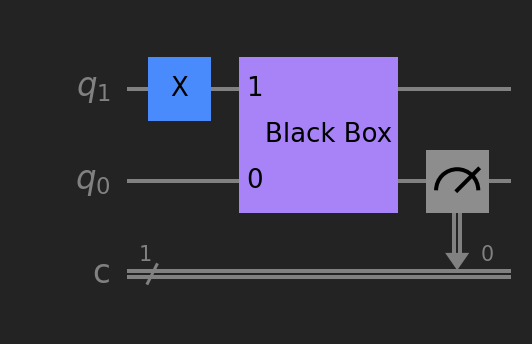

In [4]:
# Draw circuit to solve Deutsch's problem classically (input x = 1)
deutsch_classic(x=1)[0].draw()

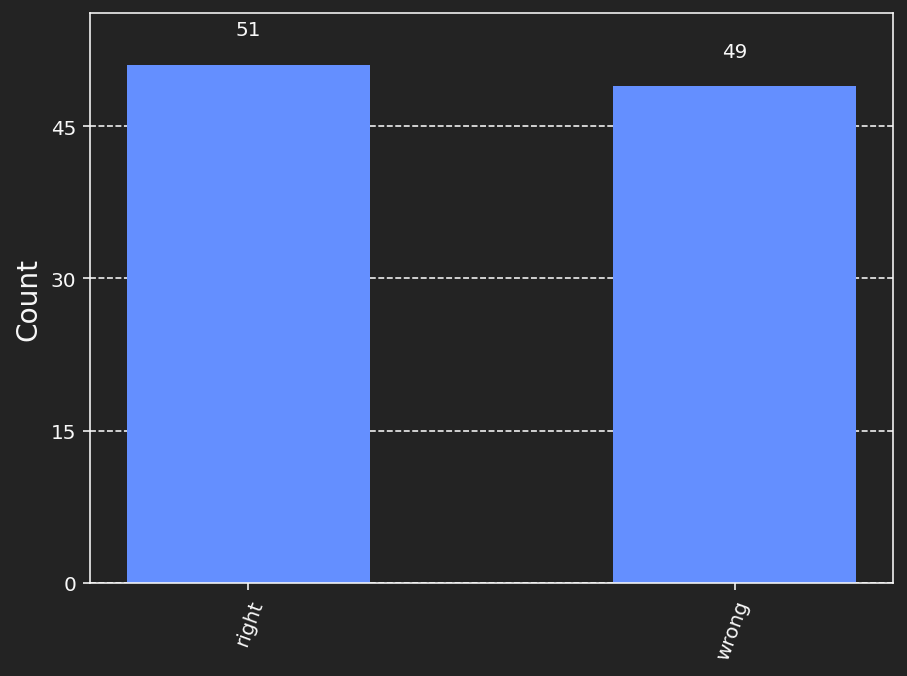

In [5]:
x = 1                            # Value of input x (can be 0 or 1)
n = 100                          # Number of times to play the game
guesses = {'right':0,'wrong':0}  # list of right/wrong guesses

simulator = AerSimulator()       # define simulator object

for i in range(n):
    qc, bb_num = deutsch_classic(x)
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 
                                                     # (we're only allowed to guess once)

    fx = job.result().get_memory()[0]        # extract output value of f(x)
     
    if (x == 0) and (fx == '0'):             # if x=0 and f(x)=0 we have either cir 1 or cir 3
        guess = np.random.choice([1,3])      # take random guess between circuit 1 or 3 (const or bal)
    
    elif (x == 0) and (fx == '1'):           # if x=0 and f(x)=1 we have either cir 2 or cir 4
        guess = np.random.choice([2,4])      # take random guess between circuit 2 or 4 (const or bal)
    
    elif (x == 1) and (fx == '0'):           # if x=1 and f(x)=0 we have either cir 1 or cir 4
        guess = np.random.choice([1,4])      # take random guess between circuit 1 or 4 (const or bal)
        
    elif (x == 1) and (fx == '1'):           # if x=1 and f(x)=1 we have either cir 2 or cir 3
        guess = np.random.choice([2,3])      # take random guess between circuit 2 or 3 (const or bal)
        
        
    if guess == bb_num:
        guesses['right'] += 1
    else:
        guesses['wrong'] += 1
        
plot_histogram(guesses)

As can be seen, we are equally likely to guess having the right type of circuit (constant or balanced) using this classical strategy. What Deutsch's algorithm enables, is the ability to **always** get the right answer in one try. But for this, we need to allow our inputs and outputs to the black to take quantum values (superposition states) rather than only being $|0\rangle$ or $|1\rangle$.

#### 1.1.2 Quantum Strategy

As mentioned before, Deutsch's problem can be summarized as trying to find if the circuit inside a black box is <span style="color:#a883f7">**constant**</span> (which results when the top and bottom qubit are independent), or <span style="color:#a883f7">**balanced**</span> (which occurs when the top qubit can affect the outcome of the bottom qubit). Deutsch's algorithm exploits the fact that we can effectively construct a circuit around our black box that deterministically changes the output state of the **top** qubit based on having (or not) a controlled gate present. To understand how this is possible, let's compare circuits 1 and 3, both of which were indistinguishable in our classical approach when the input was $x = 0$. If we were to add Hadamard gates at the input and output of our black box as follows: 

<img src="images/04_01_04_black_box_hadamard.png" align = "center" width="300"/>

we get the following equivalency for circuit 1:

<img src="images/04_01_05_cir1_equiv.png" align = "center" width="630"/>

and the following for circuit 3:

<img src="images/04_01_06_cir3_equiv.png" align = "center" width="630"/>

The result for circuit 1 is simple to explain: since the Hadamard gate is its own conjugate transpose (i.e., it is [Hermitian](https://en.wikipedia.org/wiki/Hermitian_matrix)), applying two Hadamard gates back to back to a qubit results in the identity operation (as we [pointed out](https://learnquantum.io/chapters/02_quantum_computing/02_03_single_qb_sys.html#refining-quantum-gates) before). In other words, the operation of circuit 1 was unmodified.

As for the result for circuit 3, this is exactly what we [previously observed](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#kickback-in-action) for the phase-kickback effect acting on an $X$ gate! Applying Hadamard gates before and after a $CX$ gate swaps its control direction.

Thus, if we now initialize the top qubit in state $|0\rangle$ and the bottom qubit in state $|1\rangle$, we are guaranteed to have the top output qubit in state $|0\rangle$ for circuit 1, and in state $|1\rangle$ for circuit 3, making them now distinguishable from one another. A similar analysis can be carried out for circuits 2 and 4, which again allows us to differentiate them (we will go over this step by step in the next section).

So, in summary, by wrapping our black box with Hadamard gates, we are able to distinguish a **constant** circuit from a **balanced** circuit by measuring the top qubit, and checking if the result was $|0\rangle$ or $|1\rangle$, respectively.

Let us now perform a simulation similar to that of the classical strategy and compare the times we guess if we correctly identify if the circuit we have is constant or balanced.

In [6]:
# Implement circuit to solve Deutsch's problem using Deutsch's algorithm
def deutsch_quantum():
    bb, bb_num = black_box()  # generate random black-box
    
    qc = QuantumCircuit(2,1)
    qc.x(0)                   # Initialize bottom qubit to |1〉
    qc.barrier()
    qc.h([1,0])               # Hadamard before black box
    qc.append(bb,[0,1])       # append black box to circuit
    qc.h([1,0])               # Hadamard after black box
    qc.measure(1,0)           # measure top qubit
    
    return qc, bb_num

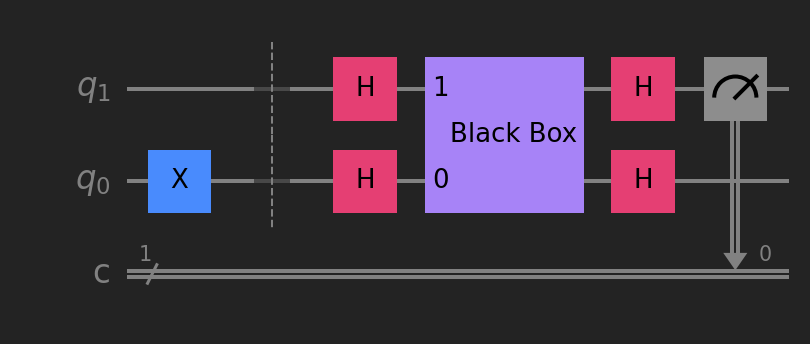

In [7]:
# Draw circuit for Deutsch's Algorithm
deutsch_quantum()[0].draw()

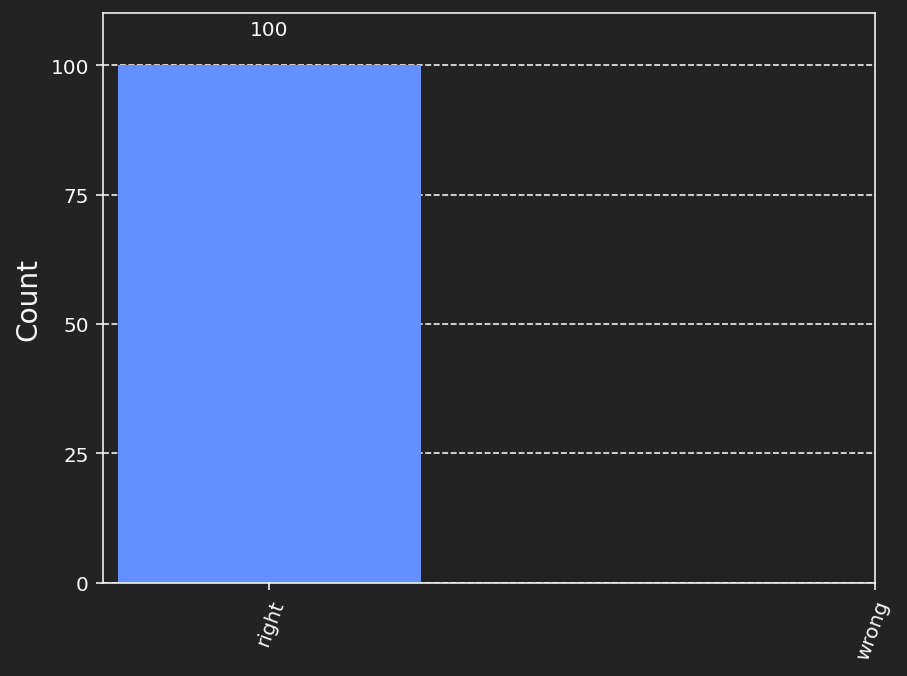

In [8]:
n = 100                           # Number of times to play the game
guesses = {'right':0,'wrong':0}   # list of right/wrong guesses

simulator = AerSimulator()        # define simulator object

for i in range(n):
    qc, bb_num = deutsch_quantum()                   # generate black box
    bb_type = 'c' if bb_num in (1, 2) else 'b'       # type of black box
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 
                                                     # (we're only allowed to guess once)

    top_qubit = job.result().get_memory()[0]         # extract output value of top qubit
    
    if top_qubit == '0':    # If top qubit is 0, we know circuit is constant (c)          
        guess = 'c'                    
    elif top_qubit == '1':  # If top qubit is 1, we know circuit is balanced (b)
        guess = 'b'
    
    if guess == bb_type:
        guesses['right'] += 1
    else:
        guesses['wrong'] += 1
        
plot_histogram(guesses)

As seen, Deutsch's algorithm provides a way to distinguish between the two different types of circuits (constant or balanced) in one try every single time.

### 1.2 Step-by-Step Description

In the previous section, we provided a general sketch of how Deutsch's algorithm works. Let's now formalize this by analyzing the circuit step by step:

<img src="images/04_01_07_deutsch.png" align = "center" width="500"/>

We start with both qubits initialized in state $|0\rangle$:

$$ |\psi \rangle_0 = |0\rangle|0\rangle, $$


followed by applying an $X$ to the bottom qubit (qubit $0$):

$$ 
\begin{aligned}
|\psi \rangle_1 &= (I \otimes X)|\psi \rangle_0
\\
\\
|\psi \rangle_1 &= |0\rangle|1\rangle .
\end{aligned}
$$

We then apply Hadamard gates to both qubits, placing qubit $1$ and qubit $0$ in the superposition states $|+\rangle$ and $|-\rangle$, respectively:

$$ 
\begin{aligned}
|\psi \rangle_2 &= (H \otimes H)|\psi \rangle_1
\\
\\
|\psi \rangle_2 &= |+\rangle|-\rangle
\\
\\
|\psi \rangle_2 &= \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle \right)
\\
\\
|\psi \rangle_2 &= \frac{1}{2}\left(|00\rangle - |01\rangle + |10\rangle - |11\rangle \right).
\end{aligned}
$$

Now, for the black box, we have four possible output states depending on which circuit is applied:

1. Apply identity gates to both qubits (i.e., do not apply any operations to either qubit)
2. Apply an $X$ gate to qubit $0$
3. Apply a $CX$ gate from qubit $1$ to qubit $0$
4. Apply a $\bar{C}X$ gate from qubit $1$ to qubit $0$

$$
\begin{split} |\psi \rangle_3 = 
\begin{cases}
    (I \otimes I)|\psi \rangle_2 & \text{if } f(x) = 0
    \\
    \\
    (I \otimes X)|\psi \rangle_2 & \text{if } f(x) = 1
    \\
    \\
    CX|\psi \rangle_2 & \text{if } f(x) = x
    \\
    \\
    \bar{C}X|\psi \rangle_2 & \text{if } f(x) = \bar{x} .
\end{cases}
\end{split}
$$

This explicitly results in the following states:

$$
\begin{split} |\psi \rangle_3 = 
\begin{cases}
    \frac{1}{2}\left(|00\rangle - |01\rangle + |10\rangle - |11\rangle \right) & \text{if } f(x) = 0
    \\
    \\
    -\frac{1}{2}\left(|00\rangle - |01\rangle + |10\rangle - |11\rangle \right) & \text{if } f(x) = 1
    \\
    \\
    \frac{1}{2}\left(|00\rangle - |01\rangle - |10\rangle + |11\rangle \right) & \text{if } f(x) = x
    \\
    \\
    -\frac{1}{2}\left(|00\rangle - |01\rangle - |10\rangle + |11\rangle \right) & \text{if } f(x) = \bar{x} ,
\end{cases}
\end{split}
$$

which can be factorized as:

$$
\begin{split} |\psi \rangle_3 = 
\begin{cases}
    |+\rangle|-\rangle & \text{if } f(x) = 0
    \\
    \\
    -|+\rangle|-\rangle & \text{if } f(x) = 1
    \\
    \\
    |-\rangle|-\rangle & \text{if } f(x) = x
    \\
    \\
    -|-\rangle|-\rangle & \text{if } f(x) = \bar{x} .
\end{cases}
\end{split}
$$

So, applying the last set of Hadamard gates results in:

$$ |\psi \rangle_4 = (H \otimes H)|\psi \rangle_3 ,$$

which gives the four following possible outcomes:

$$
\begin{split} |\psi \rangle_3 = 
\begin{cases}
    |0\rangle|1\rangle & \text{if } f(x) = 0
    \\
    \\
    -|0\rangle|1\rangle & \text{if } f(x) = 1
    \\
    \\
    |1\rangle|1\rangle & \text{if } f(x) = x
    \\
    \\
    -|1\rangle|1\rangle & \text{if } f(x) = \bar{x} .
\end{cases}
\end{split}
$$

It can be clearly seen that, whenever we have a **constant** function ($f(x) = 0$ or $f(x) = 1$) the final state for qubit $1$ is always $|0\rangle$. On the other hand, when the function is **balanced** (($f(x) = x$ or $f(x) = \bar{x}$), the final state qubit $1$ will always be $|1\rangle$.

It is worth noting that, since all we need to make the distinction between the two types of functions is to measure the top qubit (qubit $1$), the last Hadamard gate on the bottom qubit is not really necessary. However, it is nice to return this qubit to the computational basis to make the results look a bit cleaner.

### 1.3 A Slightly More Formal Derivation

In the previous section we showed how Deutsch's algorithm allows us to differentiate between a constant and a balanced function by analyzing each of the four possible circuits separately. Alternatively, we can summarize the derivation in a more compact way by using the concepts introduced in the chapter on [quantum function evaluation](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#boolean-functions-as-quantum-circuits). 

<img src="images/04_01_08_Uf.png" align = "center" width="700"/>

Let's recall that, when given a unitary $U_f$ that encodes a classical function $f(x)$ (which is precisely what the black box in Deutsch's problem does), the evolution of an input state $|x\rangle \otimes |y\rangle$ (with $x, y \in \{0,1\}$) through this unitary is given by:

$$ |x\rangle \otimes \ |y\rangle \xrightarrow{\; U_f \;} |x\rangle \otimes |y \oplus f(x)\rangle. $$

If we make $|y\rangle$ to be the superposition state $|-\rangle$, the input state becomes:

$$
\begin{aligned}
|x\rangle \otimes |y\rangle &= |x\rangle \otimes |-\rangle
\\
\\
|x\rangle \otimes |y\rangle &= |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
\\
\\
|x\rangle \otimes |y\rangle &= \frac{1}{\sqrt{2}}(|x\rangle |0\rangle - |x\rangle |1\rangle)
\end{aligned}
$$

Evolving this state over $U_f$, we get:

$$
\begin{aligned}
\frac{1}{\sqrt{2}}(|x\rangle |0\rangle - |x\rangle |1\rangle) \xrightarrow{\; Uf \;} & \frac{1}{\sqrt{2}}|x\rangle \otimes \left( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \right)
\\
\\
 = &\frac{1}{\sqrt{2}}(|x\rangle |f(x) \rangle - |x\rangle |\overline{f(x)} \rangle) .
\end{aligned}
$$

The key to understanding the final expression is to remember that the symbol $\oplus$ represents the XOR operation (addition modulo-2), so for $f(x) \in \{0, 1\}$ we have: $0 \oplus f(x) = f(x)$ and $1 \oplus f(x) = \overline{f(x)}.$

Now, since $f(x)$ can only take one of two values, we have two scenarios:

1. If $f(x) = 0$, the output is given by: $\frac{1}{\sqrt{2}}(|x\rangle |0 \rangle - |x\rangle |1\rangle) = |x\rangle|-\rangle.$
2. If $f(x) = 1$, the output is given by: $\frac{1}{\sqrt{2}}(|x\rangle |1 \rangle - |x\rangle |0\rangle) = -|x\rangle|-\rangle.$

The result of the evolution of such input through $U_f$ can then be summarized by the following compact expression:

$$|x\rangle \otimes |-\rangle \xrightarrow{\; Uf \;} (-1)^{f(x)}|x\rangle |-\rangle .$$

So, let's re-analyze Deutsch's algorithm using the expression above for evaluating the state evolving through the black box:

<img src="images/04_01_07_deutsch.png" align = "center" width="500"/>

0. Start with the initial state: $|\psi \rangle_0 = |0\rangle \otimes |0\rangle. $
1. Apply $X$ to qubit $0$: $ |\psi \rangle_1 = |0\rangle \otimes |1\rangle. $
2. Apply $H$ gates to both qubits: $|\psi\rangle_2 = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right) \otimes |-\rangle. $
3. Evolve $|\psi\rangle_2$ over $U_f$ (our black box) using the expression we derived above, but where the input $|x\rangle$ is now in superposition:

$$
\begin{aligned}
|\psi\rangle_3 &= U_f |\psi\rangle_2
\\
\\
|\psi\rangle_3 &= \frac{1}{\sqrt{2}}\big((-1)^{f(0)}|0\rangle  + (-1)^{f(1)}|1\rangle \big)|-\rangle.
\\
\\
\end{aligned}
$$

Here, the amplitude accompanying state $|0\rangle$ can be seen as a global phase factor, which we can factorize as follows:

$$ |\psi\rangle_3 = \frac{(-1)^{f(0)}}{\sqrt{2}}\big(|0\rangle  + (-1)^{f(0) \oplus f(1)}|1\rangle \big)|-\rangle. $$

Considering that:
- For a constant function we always have $f(0) = f(1)$, so $f(0) \oplus f(1) = 0$, which gives $(-1)^0 = 1.$ 
- For a balanced function we always have $f(0) \neq f(1)$, so $f(0) \oplus f(1) = 1$. which gives $(-1)^1 = -1.$ 

We get two possible outcomes after the black box:
- For a constant function: $|\psi\rangle_3 = (-1)^{f(0)}|+\rangle|-\rangle $
- For a balanced function: $|\psi\rangle_3 = (-1)^{f(0)}|-\rangle|-\rangle .$

4. Apply $H$ gates to both qubits, which gives us the final output states:
- For a constant function: $|\psi\rangle_4 = (-1)^{f(0)}|0\rangle|1\rangle $
- For a balanced function: $|\psi\rangle_4 = (-1)^{f(0)}|1\rangle|1\rangle .$

This is the same result we got in the previous section, which showed that, for a constant function, we will always get a $0$ if we measure the top qubit, or a $1$ if the function was balanced. 

Let's confirm these results in qiskit:

In [9]:
from qiskit.quantum_info import Statevector

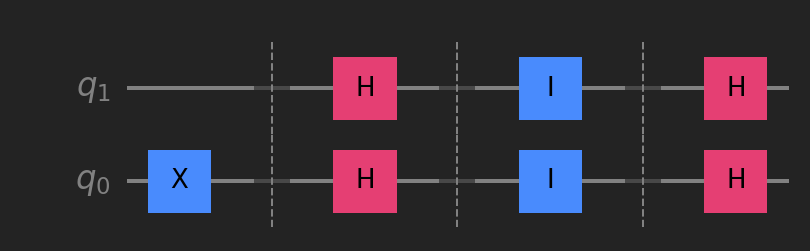

<IPython.core.display.Latex object>

In [14]:
# Circuit and output state for f(x) = 0
qc_fx_0 = QuantumCircuit(2)
qc_fx_0.x(0)
qc_fx_0.barrier()
qc_fx_0.h([1,0])
qc_fx_0.barrier()
qc_fx_0.id([1,0])
qc_fx_0.barrier()
qc_fx_0.h([1,0])
display(qc_fx_0.draw())
Statevector(qc_fx_0).draw('latex',prefix='|\\psi \\rangle_4 = ')

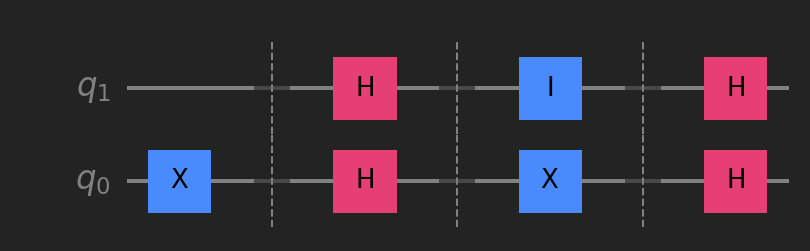

<IPython.core.display.Latex object>

In [15]:
# Circuit and output state for f(x) = 1
qc_fx_1 = QuantumCircuit(2)
qc_fx_1.x(0)
qc_fx_1.barrier()
qc_fx_1.h([1,0])
qc_fx_1.barrier()
qc_fx_1.x(0)
qc_fx_1.id(1)
qc_fx_1.barrier()
qc_fx_1.h([1,0])
display(qc_fx_1.draw())
Statevector(qc_fx_1).draw('latex',prefix='|\\psi \\rangle_4 = ')

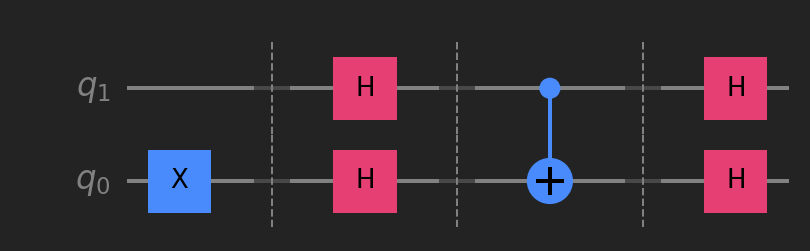

<IPython.core.display.Latex object>

In [17]:
# Circuit and output state for f(x) = x
qc_fx_x = QuantumCircuit(2)
qc_fx_x.x(0)
qc_fx_x.barrier()
qc_fx_x.h([1,0])
qc_fx_x.barrier()
qc_fx_x.cx(1,0)
qc_fx_x.barrier()
qc_fx_x.h([1,0])
display(qc_fx_x.draw())
Statevector(qc_fx_x).draw('latex',prefix='|\\psi \\rangle_4 = ')

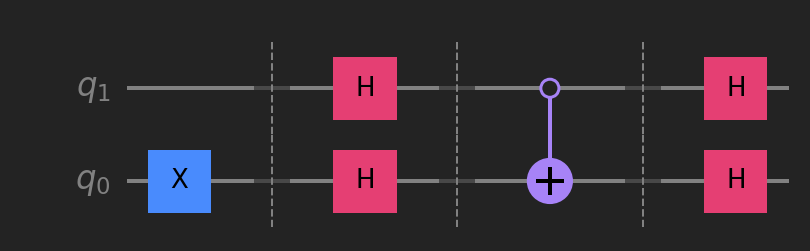

<IPython.core.display.Latex object>

In [18]:
# Circuit and output state for f(x) = x̅
qc_fx_x̅ = QuantumCircuit(2)
qc_fx_x̅.x(0)
qc_fx_x̅.barrier()
qc_fx_x̅.h([1,0])
qc_fx_x̅.barrier()
qc_fx_x̅.cx(1,0, ctrl_state='0')
qc_fx_x̅.barrier()
qc_fx_x̅.h([1,0])
display(qc_fx_x̅.draw())
Statevector(qc_fx_x̅).draw('latex',prefix='|\\psi \\rangle_4 = ')

## 2. Deutsch-Jozsa Algorithm

The Deutsch-Jozsa algorithm is the generalization of Deutsch's algorithm but where now the input $x$ to the function $f(x)$ is not a single bit, but a string of $n$ bits: $f: \{0, 1\}^n \longmapsto \{0, 1\}.$

The function $f(x)$ is **constant** if, regardless of the input string we always get the same output $f(x) = 0$ or $f(x) = 1$. For example, we can have a function $f: \{0, 1\}^2 \longmapsto \{0, 1\},$ such that:

$$
\begin{aligned}
f(00) &= 0
\\
f(01) &= 0
\\
f(10) &= 0
\\
f(11) &= 0
\end{aligned}
$$

On the other hand, $f(x)$ is **balanced** if for half of the inputs $f(x) = 0$, and for the other half $f(x) = 1$. For example: 

$$
\begin{aligned}
f(00) &= 1
\\
f(01) &= 0
\\
f(10) &= 0
\\
f(11) &= 1
\end{aligned}
$$

As before, the function f(x) is encoded in a unitary $U_f$ (black box) that we can access as:

$$ |x\rangle \otimes \ |y\rangle \xrightarrow{\; U_f \;} |x\rangle \otimes |y \oplus f(x)\rangle, $$

but where the input $|x\rangle$ is an $n$-qubit state. 

The circuit for the Deutsch-Jozsa algorithm is identical to that of Deutsch's algorithm, but where we place the input state in a superposition (by applying the [Quantum Hadamard Transform](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#the-quantum-hadamard-transform) to the whole state), and perform interference on it after accessing the function $U_f:$

<img src="images/04_01_09_deutsch-jozsa.png" align = "center" width="520"/>

Let's analyze the circuit step by step:

0. Initialize the all-zeros state: $|\psi\rangle_0 = |0\rangle^{\otimes n} \otimes |0\rangle$
1. Apply $X$ gate to bottom qubit $|p\rangle$: $|\psi\rangle_1 = |0\rangle^{\otimes n} \otimes |1\rangle$
2. Apply $H$ gate to $|p\rangle$ and $\text{QHT}$ to $|q\rangle$: $|\psi\rangle_2 = \text{QHT}_n |0\rangle^{\otimes n} \otimes H |1\rangle$

This places the input state $|q\rangle$ in an equal superposition over all possible values of $x$, and $|p\rangle$ in the minus state:

$$
|\psi\rangle_2 = \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} |x\rangle \right) \otimes |-\rangle,
$$

where $N = 2^n .$

3. Evolve the state through $U_f$:

$$
|\psi\rangle_3 = \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} (-1)^{f(x)} |x\rangle \right) \otimes |-\rangle
$$

The result above is obtained by recalling that for each value of $|x\rangle$ we have: 

$$ |x\rangle \otimes |-\rangle \xrightarrow{\; Uf \;} (-1)^{f(x)}|x\rangle \otimes |-\rangle, $$

which, by linearity, can be applied to each of the $|x\rangle$ terms in the superposition.

Here, we can make the observation that, if our function $f(x)$ is constant (i.e. $f(x) = \chi$, with $\chi \in \{0,1\}$), all the prefactors in the superposition state are the same, so we can pullout this coefficient as a global phase:

$$
|\psi\rangle_3 = (-1)^{\chi} \left(\frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1}  |x\rangle \right) \otimes |-\rangle, \; \text{when} \; f(x) \; \text{is constant} .
$$

Alternatively, when $f(x)$ is balanced, we know that half of the terms in the superposition have an associated $f(x) = 0$. Similarly, the other half have an $f(x) = 1$ exponent. Therefore, half of the terms will have positive probability amplitudes $((-1)^0 = 1)$, and the other half will be negative $((-1)^1 = -1)$:

$$
|\psi\rangle_3 = \frac{1}{\sqrt{N}} \Bigg ( \underbrace{ \sum_{x | f(x) = 0}  |x\rangle }_{N/2 \text{ terms}}  - \underbrace{ \sum_{x | f(x) = 1}  |x\rangle }_{N/2 \text{ terms}} \Bigg ) \otimes |-\rangle, \; \text{when} \; f(x) \; \text{is balanced} .
$$

4. Lastly, we again apply an $H$ gate to the bottom qubit $|p\rangle$, and $\text{QHT}$ to $|q\rangle$. We can do this by [recalling](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#the-quantum-hadamard-transform) that the $\text{QHT}$ for a basis state $|x\rangle \in \{ |0\rangle, |1\rangle \}^{\otimes n}$ is given by:

$$ \text{QHT}|x\rangle = \frac{1}{\sqrt{N}} \sum_{z = 0}^{N - 1} (-1)^{x \cdot z} |z\rangle .$$

So, for the final state we have:

$$
\begin{aligned}
|\psi\rangle_4 &= (\text{QHT}_n \otimes H) |\psi\rangle_4
\\
\\
|\psi\rangle_4 &= \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} (-1)^{f(x)} \text{QHT}_n |x\rangle \right) \otimes |1\rangle 
\\
\\
|\psi\rangle_4 &= \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} (-1)^{f(x)} \frac{1}{\sqrt{N}} \sum_{z = 0}^{N - 1} (-1)^{x \cdot z} |z\rangle \right) \otimes |1\rangle 
\end{aligned}
$$

It is also convenient to point out that the term inside the parenthesis is nothing other than the equal superposition state, which results from applying the $\text{QHT}$ to the all-zeros state. So we can express the state above as:

$$
|\psi\rangle_3 = (-1)^{\chi} \big(\text{QHT}|0\rangle^{\otimes n} \big) \otimes |-\rangle, \; \text{when} \; f(x) \; \text{is constant} .
$$